In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, AutoConfig

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/deberta-v3-large/spm.model
/kaggle/input/deberta-v3-large/config.json
/kaggle/input/deberta-v3-large/README.md
/kaggle/input/deberta-v3-large/tf_model.h5
/kaggle/input/deberta-v3-large/tokenizer_config.json
/kaggle/input/deberta-v3-large/pytorch_model.bin
/kaggle/input/cpc-codes/titles.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


# Config

In [2]:
model_name = "../input/deberta-v3-large"
max_len = 32
NUM_EPOCHS = 6
batch_size=32
LR = 1e-5
fold=5

# Reading the training and test datasets

In [3]:
train = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/train.csv")
train.head()

id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00

In [4]:
test = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/test.csv")
test.head()

id              anchor                         target context
0  4112d61851461f60            opc drum  inorganic photoconductor drum     G02
1  09e418c93a776564     adjust gas flow              altering gas flow     F23
2  36baf228038e314b      lower trunnion                 lower locating     B60
3  1f37ead645e7f0c8       cap component                  upper portion     D06
4  71a5b6ad068d531f  neural stimulation      artificial neural network     H04

# Importing *Cooperative Patent Classification Codes Meaning* dataset
More details regarding the dataset can be found [here](https://www.kaggle.com/datasets/xhlulu/cpc-codes)

In [5]:
title = pd.read_csv("../input/cpc-codes/titles.csv")
title.head()

code                                              title section  class  \
0         A                                  HUMAN NECESSITIES       A    NaN   
1       A01  AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...       A    1.0   
2      A01B  SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...       A    1.0   
3  A01B1/00  Hand tools (edge trimmers for lawns A01G3/06  ...       A    1.0   
4  A01B1/02  Spades; Shovels {(hand-operated dredgers E02F3...       A    1.0   

  subclass  group  main_group  
0      NaN    NaN         NaN  
1      NaN    NaN         NaN  
2        B    NaN         NaN  
3        B    1.0         0.0  
4        B    1.0         2.0

# Merging the CPCC dataset with both of the training and test datasets

In [6]:
train = pd.merge(train, title[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

test = pd.merge(test, title[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

In [7]:
train.head()

id     anchor                  target context  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst     A47   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00  A47   

                                               title  
0  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
1  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
2  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
3  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
4  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...

In [8]:
test.head()

id              anchor                         target  \
0  4112d61851461f60            opc drum  inorganic photoconductor drum   
1  09e418c93a776564     adjust gas flow              altering gas flow   
2  36baf228038e314b      lower trunnion                 lower locating   
3  1f37ead645e7f0c8       cap component                  upper portion   
4  71a5b6ad068d531f  neural stimulation      artificial neural network   

  context code                                              title  
0     G02  G02                                             OPTICS  
1     F23  F23         COMBUSTION APPARATUS; COMBUSTION PROCESSES  
2     B60  B60                                VEHICLES IN GENERAL  
3     D06  D06  TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...  
4     H04  H04                   ELECTRIC COMMUNICATION TECHNIQUE

# Performing data pre-processing on the training and test set data
#### Dropping the *context* column

In [9]:
train = train.drop(["context"],axis=1)
train.head()

id     anchor                  target  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region   0.00  A47   

                                               title  
0  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
1  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
2  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
3  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
4  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...

In [10]:
test = test.drop(["context"],axis=1)
test.head()

id              anchor                         target code  \
0  4112d61851461f60            opc drum  inorganic photoconductor drum  G02   
1  09e418c93a776564     adjust gas flow              altering gas flow  F23   
2  36baf228038e314b      lower trunnion                 lower locating  B60   
3  1f37ead645e7f0c8       cap component                  upper portion  D06   
4  71a5b6ad068d531f  neural stimulation      artificial neural network  H04   

                                               title  
0                                             OPTICS  
1         COMBUSTION APPARATUS; COMBUSTION PROCESSES  
2                                VEHICLES IN GENERAL  
3  TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...  
4                   ELECTRIC COMMUNICATION TECHNIQUE

**Transform the *anchor* and *target* features into lowercase.**

In [11]:
train['anchor'] = train['anchor'].str.lower()
train['target'] = train['target'].str.lower()
test['anchor'] = test['anchor'].str.lower()
test['target'] = test['target'].str.lower()
train.head()

id     anchor                  target  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region   0.00  A47   

                                               title  
0  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
1  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
2  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
3  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
4  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...

**Removing punctuations from *anchor* and *target* features**

In [12]:
train['anchor'] = train['anchor'].str.replace('[^\w\s]','',regex=True)
train['target'] = train['target'].str.replace('[^\w\s]','',regex=True)
test['anchor'] = test['anchor'].str.replace('[^\w\s]','',regex=True)
test['target'] = test['target'].str.replace('[^\w\s]','',regex=True)
train.head()

id     anchor                  target  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region   0.00  A47   

                                               title  
0  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
1  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
2  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
3  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...  
4  FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...

**Removing punctutations from the *title* feature**

In [13]:
import re
train["title"] = train["title"].apply(lambda x:re.sub('[;,]', '', x))
test["title"] = test["title"].apply(lambda x:re.sub('[;,]', '', x))

In [14]:
train.head()

id     anchor                  target  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region   0.00  A47   

                                               title  
0  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
1  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
2  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
3  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
4  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...

In [15]:
test.head()

id              anchor                         target code  \
0  4112d61851461f60            opc drum  inorganic photoconductor drum  G02   
1  09e418c93a776564     adjust gas flow              altering gas flow  F23   
2  36baf228038e314b      lower trunnion                 lower locating  B60   
3  1f37ead645e7f0c8       cap component                  upper portion  D06   
4  71a5b6ad068d531f  neural stimulation      artificial neural network  H04   

                                               title  
0                                             OPTICS  
1          COMBUSTION APPARATUS COMBUSTION PROCESSES  
2                                VEHICLES IN GENERAL  
3  TREATMENT OF TEXTILES OR THE LIKE LAUNDERING F...  
4                   ELECTRIC COMMUNICATION TECHNIQUE

# Stratified K-fold cross validation
Implementing the stratified K-fold cross validation method in our training set. The logic behind the following code has been taken from the following Kaggle Notebook given [here](https://www.kaggle.com/code/abhishek?scriptVersionId=90918173&cellId=2)

In [16]:
from sklearn import model_selection

def create_kfold_dataset(dataset, num_splits):
    # we create a new column called kfold and fill it with -1
    dataset["kfold"] = -1
    # the next step is to randomize the rows of the data
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    
    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(dataset))))
    
    # bin targets
    dataset.loc[:, "bins"] = pd.cut(dataset["score"], bins=num_bins, labels=False)
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=dataset, y=dataset.bins.values)):
        dataset.loc[v_, 'kfold'] = f
    
    # drop the bins column
    dataset = dataset.drop("bins", axis=1)

    # return dataframe with folds
    return dataset.copy()

In [17]:
train.head()

id     anchor                  target  score code  \
0  37d61fd2272659b1  abatement  abatement of pollution   0.50  A47   
1  7b9652b17b68b7a4  abatement          act of abating   0.75  A47   
2  36d72442aefd8232  abatement         active catalyst   0.25  A47   
3  5296b0c19e1ce60e  abatement     eliminating process   0.50  A47   
4  54c1e3b9184cb5b6  abatement           forest region   0.00  A47   

                                               title  
0  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
1  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
2  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
3  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...  
4  FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...

In [18]:
train = create_kfold_dataset(train.copy(), num_splits=5)
train.head()

id                      anchor  \
0  d8d4675902dcc310     orthogonal acceleration   
1  d4dd9f32ad82d4dc           operating channel   
2  3fc6ac2bc02c3090  battery monitoring circuit   
3  4112d61851461f60                    opc drum   
4  5983089372dab08c                      killed   

                                target  score code  \
0         orthogonal acceleration time   0.50  H01   
1  inactive channel selecting resource   0.25  H04   
2                short life expectancy   0.50  G01   
3        inorganic photoconductor drum   0.25  G02   
4                        cold and heat   0.00  G02   

                              title  kfold  
0           BASIC ELECTRIC ELEMENTS      1  
1  ELECTRIC COMMUNICATION TECHNIQUE      3  
2                 MEASURING TESTING      3  
3                            OPTICS      2  
4                            OPTICS      3

In [19]:
train.kfold.value_counts()

1    7295
2    7295
0    7295
3    7294
4    7294
Name: kfold, dtype: int64

# Intializing the tokenizer
**We use the deberta v2 large model from huggingface**

In [20]:
# Intializing the deberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
tokenizer

PreTrainedTokenizer(name_or_path='../input/deberta-v3-large', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [22]:
# The tokenized output shown below
encoded_input = tokenizer(train['target'][0])
print(encoded_input)

{'input_ids': [1, 51248, 13724, 326, 2], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}


In [23]:
# Saving the model in the output folder
#tokenizer.save_pretrained("./roberta_base/")

In [24]:
train.head()

id                      anchor  \
0  d8d4675902dcc310     orthogonal acceleration   
1  d4dd9f32ad82d4dc           operating channel   
2  3fc6ac2bc02c3090  battery monitoring circuit   
3  4112d61851461f60                    opc drum   
4  5983089372dab08c                      killed   

                                target  score code  \
0         orthogonal acceleration time   0.50  H01   
1  inactive channel selecting resource   0.25  H04   
2                short life expectancy   0.50  G01   
3        inorganic photoconductor drum   0.25  G02   
4                        cold and heat   0.00  G02   

                              title  kfold  
0           BASIC ELECTRIC ELEMENTS      1  
1  ELECTRIC COMMUNICATION TECHNIQUE      3  
2                 MEASURING TESTING      3  
3                            OPTICS      2  
4                            OPTICS      3

# Creating Phrase dataset for the model training
The `create_data` function creates the input data for the Deberta V3 Large model. If the `train_status` is *True* then the corresponding score value (`label`) is returned, which is primarily used during the training period of the model.

In [25]:
def create_data(id_, anchor, target, code, title, score, tokenizer, max_len, train_status=True):
    input_ids = []
    attention_mask = []
    token_type_ids = []
    labels = []
    ids = []
    encoded_sent = tokenizer.batch_encode_plus([(k[0] + " " + k[2], k[1]) for k in zip(anchor,target,title)],\
                                                max_length = max_len,\
                                                padding = "max_length", truncation = True)
    for i in range(len(anchor)): 
        ids.append(id_[i])
        input_ids.append(encoded_sent['input_ids'][i])
        attention_mask.append(encoded_sent['attention_mask'][i])
        if train_status:
            labels.append(score[i])
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "ids":ids, 
            }, labels

# Creating the training Model
We first create a basic deep learning model. More explaination will be given later.

In [26]:
import tensorflow as tf

# class custom_model(tf.keras.Model):
#     def __init__(self, model_name, MAX_LEN):
#         super(custom_model, self).__init__()
#         self.model_name = model_name
#         self.max_len = MAX_LEN
        
#         self.input__ids = tf.keras.Input(shape=(self.max_len,), dtype = tf.int32)
#         self.input__mask = tf.keras.Input(shape=(self.max_len,), dtype = tf.int32)
#         self.config = AutoConfig.from_pretrained(self.model_name, output_hidden_states=True)
#         self.transformer = TFAutoModel.from_pretrained(self.model_name, trainable=True)
#         self.xx=self.transformer(input_ids = self.input__ids, attention_mask = self.input__mask)
#         self.dropout = tf.keras.layers.Dropout(self.config.hidden_dropout_prob)
#         self.linear = tf.keras.layers.Dense(2*self.config.hidden_size,\
#                                             kernel_initializer= \
#                                             tf.keras.initializers.RandomNormal(mean=0.0,\
#                                                                                stddev=self.config.initializer_range))
#         self.num_class = tf.keras.layers.Dense(1)
    
#     def call(self, inputs):
#         input_id, input_mask = inputs
#         x=self.xx(input_id, input_mask)
#         print("here")
#         x=self.dropout(x.last_hidden_state)
#         x=self.linear(x)
#         self.final=self.num_class(x)
#         return self.final
    
    
        
def build_model(model_name, MAX_LEN):
    
    input__ids = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    input__mask = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    transformer = TFAutoModel.from_pretrained(model_name, trainable=True)
    x = transformer(input_ids = input__ids, 
                      attention_mask = input__mask)
    #print(x.last_hidden_state)
    #x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(config.hidden_dropout_prob)(x.last_hidden_state)
    x=tf.keras.layers.Dense(2*config.hidden_size,\
                            kernel_initializer= \
                            tf.keras.initializers.RandomNormal(mean=0.0,\
                                                               stddev=config.initializer_range),
                            activation='relu')(x)
    x = tf.keras.layers.Dropout(2*config.hidden_dropout_prob)(x)
    x=tf.keras.layers.Dense(2*config.hidden_size,\
                            kernel_initializer= \
                            tf.keras.initializers.RandomNormal(mean=0.0,\
                                                               stddev=config.initializer_range))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    fnl = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs = [input__ids, input__mask], 
                           outputs = fnl)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse")
    return model

In [27]:
model = build_model(model_name, max_len)
print(model.summary())

2022-05-05 05:13:48.665429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 05:13:48.666507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 05:13:48.667320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 05:13:48.668326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_deberta_v2_model (TFDebertaV TFBaseModelOutput(la 434012160   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 1024)     0           tf_deberta_v2_model[0][0]    

In [28]:
# # model.build((None,None,32))
# model = custom_model(model_name, max_len)
# input_shape1=(max_len,)
# input_shape2=(max_len,)
# model.call([(None, *input_shape1),(None, *input_shape2)])
# print(model.summary())

# Creating the callback Pearson Correlation coefficient as a tracking metrics for the model 

In [29]:
from scipy.stats import pearsonr

class PearsonCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
    #    pass
        #print(dir(self.model))
        self.X_val, self.Y_val = val_data
    #def on_epoch_start(self,epoch):
    #    print(f"Learning rate: {self.model.optimize.learning_rate}")
    def on_epoch_end(self, epoch, logs):
        X_val_preds = self.model.predict(self.X_val)
        print(X_val_preds.shape,self.Y_val.ravel().shape)
        pearson_corr = pearsonr(X_val_preds.ravel(), self.Y_val.ravel())
        print("pearsonr_val (from log) =", pearson_corr[0])
        logs["val_pearsonr"] = pearson_corr[0]

`scheduler` is the rate at which the learning rate will change in each epoch.

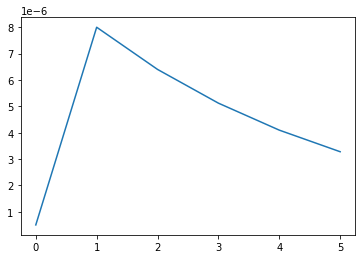

In [30]:
import matplotlib.pyplot as plt

def scheduler(epoch):
    learning_rate = LR
    if epoch == 0:
        return learning_rate * 0.05
    else:
        return learning_rate * (0.8**epoch)
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

plt.plot([scheduler(e) for e in range(NUM_EPOCHS)])

In [31]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_pearsonr', patience=2, mode='max',\
                                               verbose=1, restore_best_weights=True)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_pearsonr',factor=np.sqrt(0.1),\
                                                  cooldown=0, patience=2, min_lr=0.5e-9,mode='max')

In [32]:
# model = custom_model(model_name, max_len)
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse")

# Fitting the model to the training dataset
Generating different set of trained model, which will be trained different sets of stratified K-fold datasets. For example, the 1st training model will be train on 1, 2, 3, and 4 folds whereas validation data will be 0 fold. Whereas the 2nd model will be trained on 0, 2, 3, and 4 whereas the validation will be 1 fold.

In [33]:
for fld in range(0,fold):
    callback_save = tf.keras.callbacks.ModelCheckpoint(f'new2_deberta_v3large_patent_{fld}.h5', monitor='val_pearsonr',\
                                                       verbose=1, save_best_only=True,\
                                                       save_weights_only=True, mode='max', save_freq='epoch')

    train_data, train_labels = create_data(train[train.kfold != fld]['id'].tolist(), 
                                           train[train.kfold != fld]['anchor'].tolist(), 
                                           train[train.kfold != fld]['target'].tolist(),
                                           train[train.kfold != fld]['code'].tolist(),
                                           train[train.kfold != fld]['title'].tolist(), 
                                           train[train.kfold != fld]['score'].tolist(), 
                                           tokenizer, max_len, train_status=True)

    val_data, val_labels = create_data(train[train.kfold == fld]['id'].tolist(), 
                                           train[train.kfold == fld]['anchor'].tolist(), 
                                           train[train.kfold == fld]['target'].tolist(),
                                           train[train.kfold == fld]['code'].tolist(),
                                           train[train.kfold == fld]['title'].tolist(), 
                                           train[train.kfold == fld]['score'].tolist(), 
                                           tokenizer, max_len, train_status=True)


    val_data_ = ((np.asarray(val_data['input_ids']),
                  np.asarray(val_data['attention_mask']),
                 ),
                 np.asarray(val_labels).ravel())

    model.fit((np.asarray(train_data['input_ids']),
               np.asarray(train_data['attention_mask'])
              ),
              np.asarray(train_labels).ravel(), 
            epochs = NUM_EPOCHS,
            shuffle=True,
            callbacks = [callback_lr, PearsonCallback(val_data_), callback_save, callback_es],
            batch_size = batch_size,
            validation_data= val_data_
             )

    # model.fit((np.asarray(train_data['input_ids']),
    #            np.asarray(train_data['attention_mask']),
    #           ),
    #           np.asarray(train_labels).ravel(), 
    #         epochs = NUM_EPOCHS,
    #         shuffle=True,
    #         callbacks = [lr_reducer, callback_save, PearsonCallback(val_data_)],
    #         batch_size = batch_size,
    #         validation_data= val_data_
    #        )

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/6
912/912 [==============================] - 875s 864ms/step - loss: 0.0571 - val_loss: 0.0421
(7295, 1) (7295,)
pearsonr_val (from log) = 0.6554167448547751

Epoch 00001: val_pearsonr improved from -inf to 0.65542, saving model to new2_deberta_v3large_patent_0.h5
Epoch 2/6
912/912 [==============================] - 775s 850ms/step - loss: 0.0328 - val_loss: 0.0356
(7295, 1) (7295,)
pearsonr_val (from log) = 0.8224228348679047

Epoch 00002: val_pearsonr improved from 0.65542 to 0.82242, saving model to new2_deberta_v3large_patent_0.h5
Epoch 3/6
912/912 [==============================] - 779s 854ms/step - loss: 0.0216 - val_loss: 0.0275
(7295, 1) (7295,)
pearsonr_val (from log) = 0.8423414840578084

Epoch 00003: val_pearsonr improved from 0.82242 to 0.84234, saving model to new2_deberta_v3large_patent_0.h5
Epoch 4/6
912/912 [==============================] - 774s 848ms/step - loss: 0.0167 - val_loss: 0.0216
(7295, 1) (7295,)
pearsonr_val (from log) = 0.8473829237731848

Epoch 00

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/6
912/912 [==============================] - 780s 855ms/step - loss: 0.0125 - val_loss: 0.0069
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9502261780201133

Epoch 00001: val_pearsonr improved from -inf to 0.95023, saving model to new2_deberta_v3large_patent_1.h5
Epoch 2/6
912/912 [==============================] - 780s 856ms/step - loss: 0.0153 - val_loss: 0.0107
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9304964345552005

Epoch 00002: val_pearsonr did not improve from 0.95023
Epoch 3/6
912/912 [==============================] - 781s 857ms/step - loss: 0.0119 - val_loss: 0.0136
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9086926243169778

Epoch 00003: val_pearsonr did not improve from 0.95023
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/6
912/912 [==============================] - 786s 862ms/step - loss: 0.0118 - val_loss: 0.0071
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9500236449434845

Epoch 00001: val_pearsonr improved from -inf to 0.95002, saving model to new2_deberta_v3large_patent_2.h5
Epoch 2/6
912/912 [==============================] - 787s 863ms/step - loss: 0.0150 - val_loss: 0.0092
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9312308703350382

Epoch 00002: val_pearsonr did not improve from 0.95002
Epoch 3/6
912/912 [==============================] - 787s 862ms/step - loss: 0.0107 - val_loss: 0.0104
(7295, 1) (7295,)
pearsonr_val (from log) = 0.9289026053600734

Epoch 00003: val_pearsonr did not improve from 0.95002
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/6
912/912 [==============================] - 789s 865ms/step - loss: 0.0115 - val_loss: 0.0068
(7294, 1) (7294,)
pearsonr_val (from log) = 0.952185118205126

Epoch 00001: val_pearsonr improved from -inf to 0.95219, saving model to new2_deberta_v3large_patent_3.h5
Epoch 2/6
912/912 [==============================] - 789s 865ms/step - loss: 0.0145 - val_loss: 0.0086
(7294, 1) (7294,)
pearsonr_val (from log) = 0.9331892924945612

Epoch 00002: val_pearsonr did not improve from 0.95219
Epoch 3/6
912/912 [==============================] - 781s 856ms/step - loss: 0.0106 - val_loss: 0.0113
(7294, 1) (7294,)
pearsonr_val (from log) = 0.9303941714746403

Epoch 00003: val_pearsonr did not improve from 0.95219
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/6
912/912 [==============================] - 780s 855ms/step - loss: 0.0111 - val_loss: 0.0067
(7294, 1) (7294,)
pearsonr_val (from log) = 0.9545347764861299

Epoch 00001: val_pearsonr improved from -inf to 0.95453, saving model to new2_deberta_v3large_patent_4.h5
Epoch 2/6
912/912 [==============================] - 782s 857ms/step - loss: 0.0142 - val_loss: 0.0106
(7294, 1) (7294,)
pearsonr_val (from log) = 0.9291444728779397

Epoch 00002: val_pearsonr did not improve from 0.95453
Epoch 3/6
912/912 [==============================] - 783s 859ms/step - loss: 0.0107 - val_loss: 0.0110
(7294, 1) (7294,)
pearsonr_val (from log) = 0.9342560604119113

Epoch 00003: val_pearsonr did not improve from 0.95453
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


# Predicting the test set results

In [34]:
test_data, test_labels = create_data(test['id'].tolist(),\
                                   test['anchor'].tolist(),\
                                   test['target'].tolist(),\
                                   test['code'].tolist(),\
                                   test['title'].tolist(),\
                                   None, tokenizer, max_len,\
                                   train_status=False)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [35]:
test_preds = model.predict((np.asarray(test_data['input_ids']),
                            np.asarray(test_data['attention_mask']),
                           #np.asarray(test_data['token_type_ids']),
                           ))

In [36]:
test_preds

array([[ 0.4820254 ],
       [ 0.6837802 ],
       [ 0.5181527 ],
       [ 0.17749982],
       [-0.04977786],
       [ 0.44156858],
       [ 0.44308883],
       [-0.05467439],
       [ 0.293831  ],
       [ 1.1209027 ],
       [ 0.16677412],
       [ 0.24286292],
       [ 0.76917315],
       [ 0.9260437 ],
       [ 0.7455115 ],
       [ 0.25429818],
       [ 0.24822785],
       [-0.05332871],
       [ 0.47880325],
       [ 0.28570867],
       [ 0.41210908],
       [ 0.22654821],
       [ 0.00801767],
       [ 0.21348405],
       [ 0.5268489 ],
       [-0.05279601],
       [-0.03825317],
       [-0.05490144],
       [-0.06581992],
       [ 0.5992051 ],
       [ 0.11161997],
       [-0.03031436],
       [ 0.671241  ],
       [ 0.5423493 ],
       [ 0.26017848],
       [ 0.18410602]], dtype=float32)

# Creating the submission file

In [37]:
submission = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/sample_submission.csv")
submission['score'] = test_preds
submission['score'] = submission.score.apply(lambda x: 0 if x < 0 else x)
submission['score'] = submission.score.apply(lambda x: 1 if x > 1 else x)
submission.to_csv('submission.csv',index=False)
submission

id     score
0   4112d61851461f60  0.482025
1   09e418c93a776564  0.683780
2   36baf228038e314b  0.518153
3   1f37ead645e7f0c8  0.177500
4   71a5b6ad068d531f  0.000000
5   474c874d0c07bd21  0.441569
6   442c114ed5c4e3c9  0.443089
7   b8ae62ea5e1d8bdb  0.000000
8   faaddaf8fcba8a3f  0.293831
9   ae0262c02566d2ce  1.000000
10  a8808e31641e856d  0.166774
11  16ae4b99d3601e60  0.242863
12  25c555ca3d5a2092  0.769173
13  5203a36c501f1b7c  0.926044
14  b9fdc772bb8fd61c  0.745511
15  7aa5908a77a7ec24  0.254298
16  d19ef3979396d47e  0.248228
17  fd83613b7843f5e1  0.000000
18  2a619016908bfa45  0.478803
19  733979d75f59770d  0.285709
20  6546846df17f9800  0.412109
21  3ff0e7a35015be69  0.226548
22  12ca31f018a2e2b9  0.008018
23  03ba802ed4029e4d  0.213484
24  c404f8b378cbb008  0.526849
25  78243984c02a72e4  0.000000
26  de51114bc0faec3e  0.000000
27  7e3aff857f056bf9  0.000000
28  26c3c6dc6174b589  0.000000
29  b892011ab2e2cabc  0.599205
30  8247ff562ca185cc  0.111620
31  c057aecbba832387  0.000000
32  9f2279ce667b21dc  0.671241
33  b9ea2b06a878df6f  0.542349
34  79795133c30ef097  0.260178
35  25522ee5411e63e9  0.184106